# Data Science & Business Analytics Intern at The Sparks Foundation - GRIP APRIL'21 Batch
### Author: Sumit Mishra

##  TASK 1: Object Detection / Optical Character Recognition (OCR) (Domain: Computer Vision & Internet of Things)

* Implement an object detector which identifies the classes of the objects in
an image or video. OR
* Character detector which extracts printed or handwritten text from an
image or video.

### 1. Object Detection

#### 1.1 Importing the required header files

In [1]:
#importing the required packages
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

#### 1.2 Object detection using YOLO

In [36]:
def object_detection(frame, yolo_model, yolo_output_layer):
  '''
  This function accepts the frame of video stream or an image, yolo model and output layer of yolo model
  and returns the person prediction probability, bounding box coordinates, and the centroid.
  '''
  #Getting height and width of frame
  (H, W) = frame.shape[:2]
  results = []

	#Construct a blob from the input frame and forwarding pass of the YOLO object detector
  #and it returns bounding boxes and associated probabilities
  blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416), swapRB=True, crop=False)
  yolo_model.setInput(blob)
  layerOutputs = yolo_model.forward(yolo_output_layer)
	# initialize our lists of detected bounding boxes, centroids, and
	# confidences, respectively
  boxes, classes, confidences = [], [], []

	#Looping over each of the layer outputs
  for output in layerOutputs:
		#Looping over each of the detections
    for detection in output:
			#Getting classID and its confidencescore of the current object detection
      scores = detection[5:]
      classID = np.argmax(scores)
      confidence = scores[classID]
			#Picking only person object from detection which has confidence score more than 35%
      if confidence > 0.35:
				#Scaling the bounding box coordinates back relative to the size of the image
        #because YOLO only returns the center (x, y) coordinates of the bounding box
        #followed by the boxes width and height
        box = detection[0:4] * np.array([W, H, W, H])
        (centerX, centerY, width, height) = box.astype("int")
				#Using the center (x, y) coordinates to derive the top and left corner of the bounding box
        x = int(centerX - (width / 2))
        y = int(centerY - (height / 2))
				#Updating list of bounding box coordinates, centroids, and confidences
        boxes.append([x, y, int(width), int(height)])
        classes.append(classID)
        confidences.append(float(confidence))
    
	#Applying non-maxima suppression to suppress weak, overlapping bounding boxes
  ids = cv2.dnn.NMSBoxes(boxes, confidences, 0.35, 0.35)
	#If at least one detection exists then only store results
  if len(ids) > 0:
    for i in ids.flatten():
			#Extracting the bounding box coordinates
      (x, y) = (boxes[i][0], boxes[i][1])
      (w, h) = (boxes[i][2], boxes[i][3])
			#Storing person prediction probability, bounding box coordinates, and the centroid
      r = (confidences[i], (x, y, x + w, y + h), classes[i])
      results.append(r)

  for (i, (prob, bbox, cls)) in enumerate(results):
    (startX, startY, endX, endY) = bbox
    cv2.rectangle(frame, (startX, startY), (endX, endY), (255,0,0), 1)
    text = labels[cls]+" ("+str('%.2f' % (prob*100))+"%)"
    cv2.putText(frame, text, (startX, startY), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 0, 0), 2)

  return frame

#### 1.3 Loading YOLO model, its weights and COCO class labels

In [2]:
#Loading YOLO weights

#!wget https://pjreddie.com/media/files/yolov3.weights

--2021-04-12 06:15:20--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  79.5MB/s    in 3.0s    

2021-04-12 06:15:23 (79.5 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [3]:
#Loading the COCO class labels
labels = open("/content/coco.names").read().strip().split("\n")

#Loading YOLO object detector trained on COCO dataset with 80 classes
yolo_model = cv2.dnn.readNetFromDarknet("/content/yolov3.cfg", "/content/yolov3.weights")
 
#Picking only the output layer names that we need from YOLO
yolo_output_layer = yolo_model.getLayerNames()
yolo_output_layer = [yolo_output_layer[i[0] - 1] for i in yolo_model.getUnconnectedOutLayers()]

#### 1.4 Testing object detection function in an image

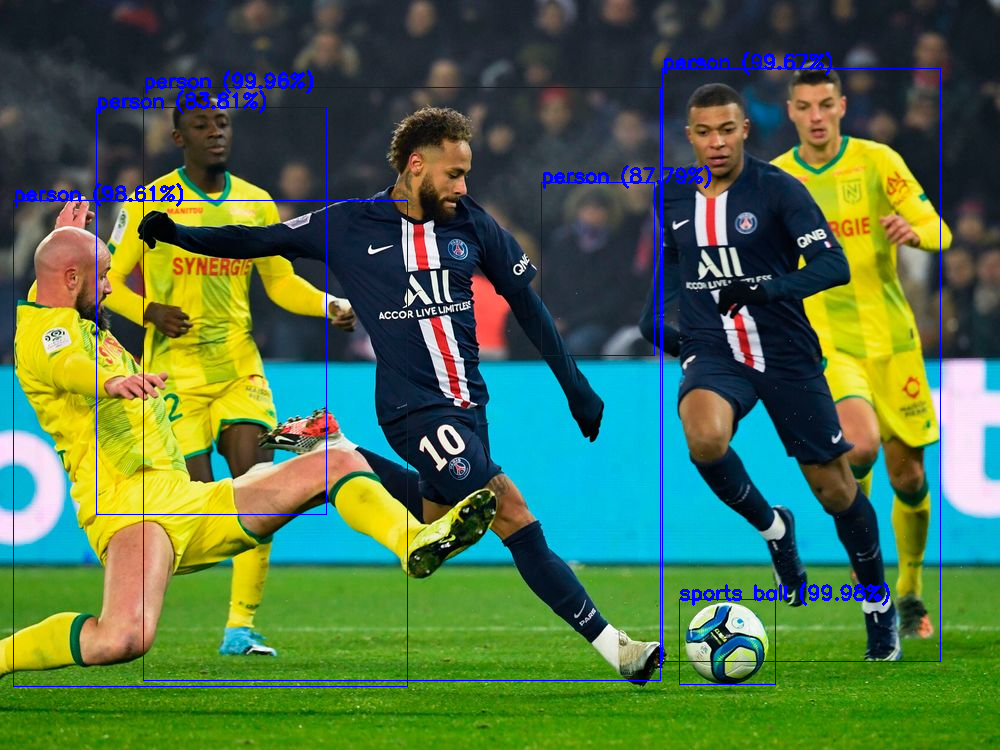

In [38]:
cv2_imshow(object_detection(cv2.imread("/content/soccer.jpg"),yolo_model,yolo_output_layer))

#### 1.5 Conclusion

* As we can see, YOLO object detection model is able to detect most of the objects from an image.
* If we look closely, in above image YOLO model is able to detect the person in the audience very accurately.
* YOLO model is able to detect 80 categories of objects. 
* This can be further extended to detect objects in video stream also, we just need to pick each frame from video and pass it to this function. So, I'll just limit the scope of it till image object detection only.
* If you want to try it using video, just pass each frame to this function and merge resultant frame. For reference, you can visit my previous post.

### 2. OCR (Optical Character Rocognition)

#### 2.1 Importing the required header files

In [ ]:
#importing the required packages
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

In [40]:
#Installing EasyOCR library
#It is a Python package that allows to effortlessly perform Optical Character Recognition.
#When it comes to OCR, EasyOCR is by far the most straightforward way to apply Optical Character Recognition.
!pip install easyocr
import easyocr
#Setting the language as English for detection/recognition
reader = easyocr.Reader(['en'])

     |████████████████████████████████| 63.0MB 47kB/s 


#### 2.2 OCR solution using EasyOCR library

In [51]:
def easyocr_engine(image):
  '''
  This function returns the coords for detected text using easyOCR
  '''
  coords = []
  
  #Getting predictions using EasyOCR which is array of coords, recognized text & confidence percentage
  op = reader.readtext(image)

  #Drawing polygon on images using predicted coords and putting recognized text onto it
  for i in range(len(op)):

    #pts contains coords for each detected text
    pts = np.array(op[i][0])
    coords.append(np.int32(pts))
    
    #Drawing a polygon on original image
    cv2.polylines(image, np.int32([pts]),True,(0,255,0),2)
    
    #Putting text near detected text regions
    cv2.putText(image, op[i][-2], (int(op[i][0][0][0]), int(op[i][0][0][1]-7)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
  
  return image

#### 2.3 Testing EasyOCR in an image

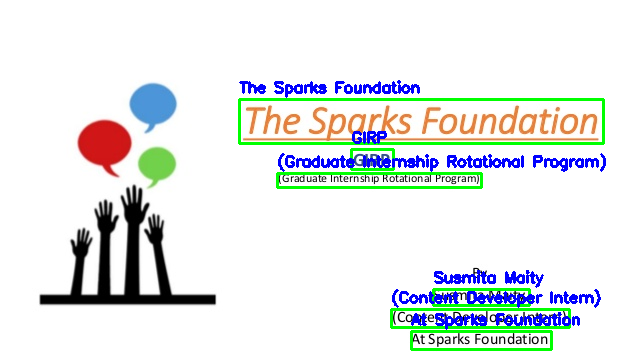

In [52]:
cv2_imshow(easyocr_engine(cv2.imread('/content/tsf.jpg')))

#### 2.4 Conclusion

* As we can see, our OCR is able to detect most of the characters from an image very accurately.
* This can be further extended to detect objects in video stream also, we just need to pick each frame from video and pass it to this function. So, I'll just limit the scope of it till image object detection only.
* If you want to try it using video, just pass each frame to this function and merge resultant frame. For reference, you can visit my previous post.
* If you want to build your own OCR solution from scratch, kindly visit my blog in the given below link where I have explained everything, such as need of this system, data collection, exploratory data analysis, old or current solution, modern or deep learning based solution, experiments with pre-trained OCR, custom trained OCR, translation of recognized text by OCR, etc.
* Blog link: https://medium.com/swlh/scene-text-detection-recognition-translation-8518210aed01